In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from GibsonPrediction.clustering import read_starcode_results, cluster_counter_to_count_df
from GibsonPrediction.utils import contains_RE_site, get_fold_change

The reads from the assembled library were appended to the reads from the input library before clustering. I want to separate them back into input vs assembled, so I need to determine how many reads were in the input library. I'll read in the reads from the input and make sure they're all length 30 before counting how many there are.

In [2]:
with open('../data/starcode_counts/GP_PCR_2_trimmed.txt', 'r') as f:
  input_reads = [line.rstrip() for line in f]

print(sum([len(read) != 30 for read in input_reads]))
print(len(input_reads))

total_reads_input = len(input_reads)

0
12436507


Read in clusters from starcode output, as well as the input file so that individual cluster IDs can be mapped back to their original sequences.

In [3]:
clustered_path = '../data/starcode_counts/PCR_large_rep1_clustered_d3.txt'
unclustered_path = '../data/starcode_counts/PCR_large_rep1.txt'

In [4]:
cluster_counts_input, cluster_counts_assembled = read_starcode_results(clustered_path, unclustered_path, input_count=total_reads_input)

In [5]:
count_df = cluster_counter_to_count_df(cluster_counts_input, cluster_counts_assembled)
count_df.head()

,sequence,input_count,assembled_count
0,CTATAGGTCGCTCTACTTAGCCTCAAGGCA,11,10
1,TGGGGCGGGTGTGCGGAACTTCCGGCCAAA,8,11
2,AAAGACCTTGCTCTCTTTTCCGTGTTCACT,17,18
3,GCTGTATTCCGAGTGTACGTTTTCCCGTGT,1,0
4,TGGTTCCTTACCAGTTCGACCGATCCGGTC,42,31


In [6]:
del cluster_counts_input, cluster_counts_assembled

Look at cluster stats.

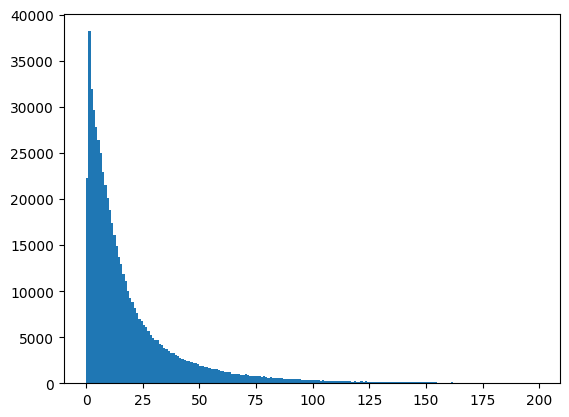

Median count: 11.0
count    590709.000000
mean         21.053526
std          32.462215
min           0.000000
25%           4.000000
50%          11.000000
75%          25.000000
max         994.000000
Name: input_count, dtype: float64


In [7]:
plt.hist(count_df['input_count'], bins=range(200))
plt.show()
print(f"Median count: {count_df['input_count'].median()}")
print(count_df['input_count'].describe())


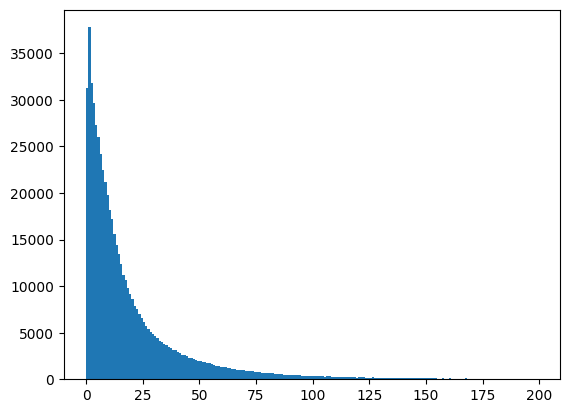

Median count: 11.0
count    590709.000000
mean         20.882888
std          32.196014
min           0.000000
25%           4.000000
50%          11.000000
75%          25.000000
max        1005.000000
Name: assembled_count, dtype: float64


In [8]:
plt.hist(count_df['assembled_count'], bins=range(200))
plt.show()
print(f"Median count: {count_df['assembled_count'].median()}")
print(count_df['assembled_count'].describe())

See if any sequences have input count of 0 before calculating fold change

In [9]:
count_df[count_df['input_count'] == 0].sort_values('assembled_count', ascending=False)

,sequence,input_count,assembled_count
547220,GCGGGACCTACGAAAACTGGGCCCACCGGC,0,18
497448,ATAGAGTCGAGAAGGTGCGTCTTCGTTCTT,0,16
456039,CACGTTAATTGAGTACGGAGATCGCCATCG,0,15
335230,ACGCATCCGAGTCGAAACATGGTGCACTGA,0,15
174556,CCTGGACGGGAAGGGGGGGGAAAAGTCAAT,0,14
...,...,...,...
358191,AAAGAACCAGTAGGAGGTGGTTCTTAAGGC,0,1
145243,CGAACATTCTACATCCGGCGAGTGCGACTC,0,1
358240,GGTTTCACCTCTGTAGGTATGTGGCTAACC,0,1
145216,GTAGTGGCTGAACCACGAATTTCCGATTGA,0,1


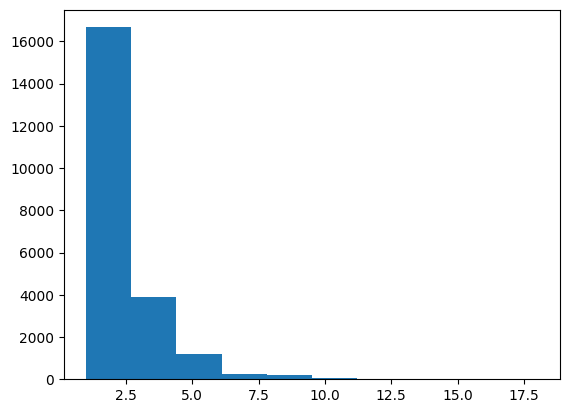

In [10]:
plt.hist(count_df[count_df['input_count'] == 0]['assembled_count'])
plt.show()

Look at distribution of ratio between assembled and input counts for each cluster.

In [11]:
count_df['fold_change'] = get_fold_change(count_df, 1, 1)
count_df['log2_FC'] = np.log2(count_df['fold_change'])
count_df.head()

,sequence,input_count,assembled_count,fold_change,log2_FC
0,CTATAGGTCGCTCTACTTAGCCTCAAGGCA,11,10,0.924157,-0.113790
1,TGGGGCGGGTGTGCGGAACTTCCGGCCAAA,8,11,1.344228,0.426778
2,AAAGACCTTGCTCTCTTTTCCGTGTTCACT,17,18,1.064181,0.089743
3,GCTGTATTCCGAGTGTACGTTTTCCCGTGT,1,0,0.504086,-0.988259
4,TGGTTCCTTACCAGTTCGACCGATCCGGTC,42,31,0.750267,-0.414524


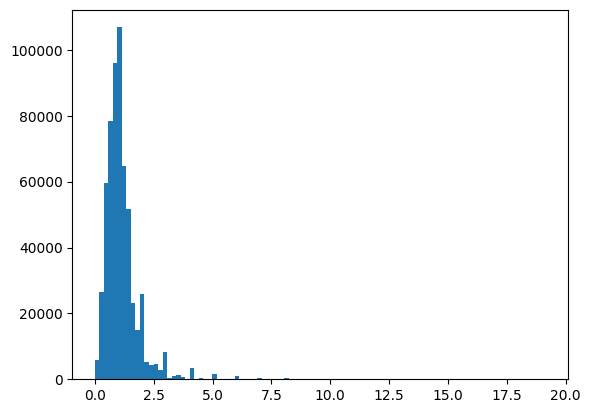

In [12]:
plt.hist(count_df['fold_change'], bins=100)
plt.show()

Look at stats for log fold change

count    590709.000000
mean         -0.041066
std           0.849990
min          -8.993884
25%          -0.473686
50%           0.011741
75%           0.426778
max           4.259668
Name: log2_FC, dtype: float64


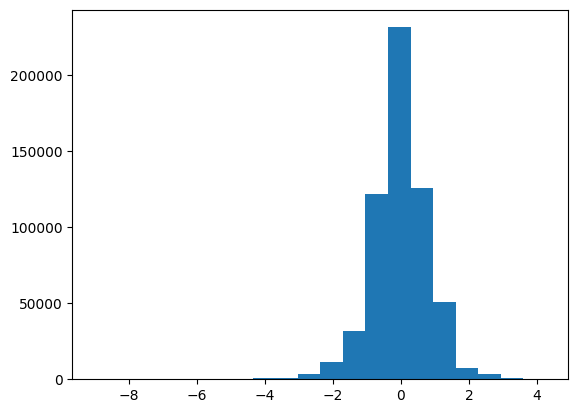

In [13]:
print(count_df['log2_FC'].describe())
plt.hist(count_df['log2_FC'], bins=20)
plt.show()

Look at best and worst sequences for Gibson assembly

In [14]:
count_df[(count_df['input_count'] > 100) & (count_df['assembled_count'] < 20)].sort_values('log2_FC')

,sequence,input_count,assembled_count,fold_change,log2_FC
228158,TAGAAGCCGTCCGTGGGAGTCCTGATACAG,513,0,0.001961,-8.993884
442737,GATGGGCTATAGTGCTCTTCAAGTGCAGTG,410,0,0.002453,-8.671254
489230,TTCCAAGGGAGCGTTTCGGGGTCATCTTAG,377,0,0.002667,-8.550502
40039,GGGTGGTCTGCAGAGATGCGGTCCGTATCA,376,0,0.002674,-8.546680
21215,GGCAAGTAGGTGGCTGCGATTAGTTGACGG,316,0,0.003180,-8.296598
...,...,...,...,...,...
324338,TTGAGTCCATGCGCGGGGCGTGGTTTTTTC,140,18,0.135853,-2.879883
226612,CATGAGTGTGGTCAGTGGCCAGGATGGGCA,109,15,0.146643,-2.769619
125259,AGGAGGTCGTTGCTCTTCATGCAGTTGCCA,127,19,0.157527,-2.666331
481883,GGAAGCATTTCGGGGAAGAGCGGGATTAGT,121,19,0.165274,-2.597069


In [15]:
count_df[(count_df['input_count'] > 20)].sort_values('log2_FC', ascending=False)

,sequence,input_count,assembled_count,fold_change,log2_FC
432081,AGGGTACCGCGCATGAAATCAGCCAGCTCG,21,61,2.841210,1.506505
486207,CATACACGAAACTTGGCCCGGCAAGGTCAT,21,60,2.795384,1.483046
18392,TTTTGCTTGTACTCATCTCAGCGTGGTCGC,28,79,2.781162,1.475688
244613,GCCTTAAAGGGGTACGGAGAGTGGGGACCA,22,60,2.673845,1.418916
40228,TGGAGATTTCCGTAGGCAGGCGTAGATATA,21,57,2.657906,1.410290
...,...,...,...,...,...
21215,GGCAAGTAGGTGGCTGCGATTAGTTGACGG,316,0,0.003180,-8.296598
40039,GGGTGGTCTGCAGAGATGCGGTCCGTATCA,376,0,0.002674,-8.546680
489230,TTCCAAGGGAGCGTTTCGGGGTCATCTTAG,377,0,0.002667,-8.550502
442737,GATGGGCTATAGTGCTCTTCAAGTGCAGTG,410,0,0.002453,-8.671254


Remove sequences that contain a BspQI site and look at worst sequences again.

In [16]:
mask = count_df['sequence'].apply(lambda x: contains_RE_site(x, 'GCTCTTC'))
count_df[mask].sort_values('input_count', ascending=False).head()
# count_df[mask].sort_values('input_count', ascending=False).to_csv('cut.csv', sep='\t')

,sequence,input_count,assembled_count,fold_change,log2_FC
442737,GATGGGCTATAGTGCTCTTCAAGTGCAGTG,410,0,0.002453,-8.671254
250315,GGTAGCTTTGGGATGCGGCGAAGAGCTCCA,283,245,0.873275,-0.195492
542768,GCCCTAGAGGTAAGGAAGAGCTTTAACGTT,243,5,0.024791,-5.334034
379900,GCTCTTCCGGGTGGCGGACAATGGCGCTTT,206,219,1.071486,0.099613
62381,TCCCCCGGCTTTTGGGCTCTTCTTGGCAGG,193,1,0.010394,-6.588172


In [17]:
count_df_no_cut = count_df[~mask]
count_df_no_cut[(count_df_no_cut['input_count'] > 100) & (count_df_no_cut['assembled_count'] < 20)].sort_values('log2_FC')

,sequence,input_count,assembled_count,fold_change,log2_FC
228158,TAGAAGCCGTCCGTGGGAGTCCTGATACAG,513,0,0.001961,-8.993884
489230,TTCCAAGGGAGCGTTTCGGGGTCATCTTAG,377,0,0.002667,-8.550502
40039,GGGTGGTCTGCAGAGATGCGGTCCGTATCA,376,0,0.002674,-8.546680
21215,GGCAAGTAGGTGGCTGCGATTAGTTGACGG,316,0,0.003180,-8.296598
180588,AGCGTGGGCGCACGCCAGTCTTTAGGCGTT,304,0,0.003305,-8.240925
...,...,...,...,...,...
248504,CTTCGGGAGTGTCAGTCAATGAATACGGAT,119,13,0.117620,-3.087795
75193,GTCTTCCCGATGCTTGGTGGCCTATCGCGC,104,13,0.134423,-2.895150
324338,TTGAGTCCATGCGCGGGGCGTGGTTTTTTC,140,18,0.135853,-2.879883
226612,CATGAGTGTGGTCAGTGGCCAGGATGGGCA,109,15,0.146643,-2.769619
